In [2]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_IT.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IT_modes/functions_IT_modes_v1.ipynb

In [3]:
M2 = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/FES/M2.FES2014b.nc")
N2 = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/FES/N2.FES2014b.nc")
S2 = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/FES/S2.FES2014b.nc")

In [ ]:
plt.figure()
plt.pcolormesh(M2.longitude, M2.latitude, M2.elevation_a)
plt.show()

In [ ]:
# Define the dataset boundaries
lon_min, lon_max = 159.23333740234375, 172.34999084472656
lat_min, lat_max = -28.803945541381836, -15.699763298034668

# Function to crop the dataset and extract amplitude and phase
def crop_and_extract(dataset):
    # Get the indices for the cropping
    lon_indices = np.where((dataset['longitude'].values >= lon_min) & (dataset['longitude'].values <= lon_max))[0]
    lat_indices = np.where((dataset['latitude'].values >= lat_min) & (dataset['latitude'].values <= lat_max))[0]

    # Crop the dataset using the indices
    cropped = dataset.isel(nx=lon_indices, ny=lat_indices)

    # Extract amplitude and phase from the cropped dataset
    amplitude = cropped['elevation_a'].values  # Amplitude in meters
    phase = cropped['elevation_G'].values      # Phase in degrees

    # Convert phase from degrees to radians
    phase_rad = np.deg2rad(phase)

    return amplitude, phase_rad, cropped['longitude'].values, cropped['latitude'].values

# Crop and extract for each component
M2_amplitude, M2_phase, longitude, latitude = crop_and_extract(M2)
S2_amplitude, S2_phase, _, _ = crop_and_extract(S2)
N2_amplitude, N2_phase, _, _ = crop_and_extract(N2)

# Constants for angular frequencies
omega_M2 = 2 * np.pi / 12.42  # Example angular frequency for M2 tide (12.42 hours period)
omega_S2 = 2 * np.pi / 12.00  # Example angular frequency for S2 tide (12.00 hours period)
omega_N2 = 2 * np.pi / 12.66  # Example angular frequency for N2 tide (12.66 hours period)

# Define the dimensions and coordinates
nx = len(longitude)
ny = len(latitude)
times = pd.date_range('1900-01-01 00:30', '2014-12-31 23:30', freq='H')

# Function to compute the wave at a specific time index for all components
def compute_wave_at_time(t_idx):
    wave_M2 = M2_amplitude * np.cos(omega_M2 * t_idx + M2_phase)
    wave_S2 = S2_amplitude * np.cos(omega_S2 * t_idx + S2_phase)
    wave_N2 = N2_amplitude * np.cos(omega_N2 * t_idx + N2_phase)
    return wave_M2 + wave_S2 + wave_N2

# Compute the wave for each time step in parallel using joblib
wave = Parallel(n_jobs=-1, verbose=10)(delayed(compute_wave_at_time)(t_idx) for t_idx in range(len(times)))

# Convert the list of arrays to a numpy array
wave = np.array(wave)

# Create the xarray.Dataset
bar_fes = xr.Dataset(
    {
        'bar': (('time', 'latitude', 'longitude'), wave)
    },
    coords={
        'time': times,
        'latitude': latitude,
        'longitude': longitude
    }
)

In [14]:
import numpy as np
import pandas as pd
import xarray as xr
from joblib import Parallel, delayed

# Define the dataset boundaries
lon_min, lon_max = 159.23333740234375, 172.34999084472656
lat_min, lat_max = -28.803945541381836, -15.699763298034668

# Function to crop the dataset and extract amplitude and phase
def crop_and_extract(dataset):
    # Get the indices for the cropping
    lon_indices = np.where((dataset['longitude'].values >= lon_min) & (dataset['longitude'].values <= lon_max))[0]
    lat_indices = np.where((dataset['latitude'].values >= lat_min) & (dataset['latitude'].values <= lat_max))[0]

    # Crop the dataset using the indices
    cropped = dataset.isel(nx=lon_indices, ny=lat_indices)

    # Extract amplitude and phase from the cropped dataset
    amplitude = cropped['elevation_a'].values  # Amplitude in meters
    phase = cropped['elevation_G'].values      # Phase in degrees

    # Convert phase from degrees to radians
    phase_rad = np.deg2rad(phase)

    return amplitude, phase_rad, cropped['longitude'].values, cropped['latitude'].values

# Crop and extract for each component
M2_amplitude, M2_phase, longitude, latitude = crop_and_extract(M2)
S2_amplitude, S2_phase, _, _ = crop_and_extract(S2)
N2_amplitude, N2_phase, _, _ = crop_and_extract(N2)

# Constants for angular frequencies
omega_M2 = 2 * np.pi / 12.42  # Example angular frequency for M2 tide (12.42 hours period)
omega_S2 = 2 * np.pi / 12.00  # Example angular frequency for S2 tide (12.00 hours period)
omega_N2 = 2 * np.pi / 12.66  # Example angular frequency for N2 tide (12.66 hours period)

# Generate the full time range from 1900 to 2014
full_times = pd.date_range('1992-01-01 00:30', '2014-12-31 23:30', freq='H')

# Filter the time range to only include dates from 2014
times_2014 = full_times[full_times.year == 2014]

# Function to compute the wave at a specific time index for all components
def compute_wave_at_time(t_idx):
    wave_M2 = M2_amplitude * np.cos(omega_M2 * t_idx + M2_phase)
    wave_S2 = S2_amplitude * np.cos(omega_S2 * t_idx + S2_phase)
    wave_N2 = N2_amplitude * np.cos(omega_N2 * t_idx + N2_phase)
    return wave_M2 + wave_S2 + wave_N2

# Compute the wave only for the filtered time indices
start_idx = full_times.get_loc(times_2014[0])
end_idx = full_times.get_loc(times_2014[-1]) + 1

wave = Parallel(n_jobs=-1, verbose=10)(delayed(compute_wave_at_time)(t_idx) for t_idx in range(start_idx, end_idx))

# Convert the list of arrays to a numpy array
wave = np.array(wave)

# Create the xarray.Dataset
bar_fes = xr.Dataset(
    {
        'bar': (('time', 'latitude', 'longitude'), wave)
    },
    coords={
        'time': times_2014,
        'latitude': latitude,
        'longitude': longitude
    }
)

# Display the result
bar_fes


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19358778790065376s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12836647033691406s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12128400802612305s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    1.6s
[Parallel(n_job

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 8760, latitude: 209, longitude: 210)
Coordinates:
  * time       (time) datetime64[ns] 70kB 2014-01-01T00:30:00 ... 2014-12-31T...
  * latitude   (latitude) float64 2kB -28.75 -28.69 -28.62 ... -15.81 -15.75
  * longitude  (longitude) float64 2kB 159.2 159.3 159.4 ... 172.2 172.2 172.3
Data variables:
    bar        (time, latitude, longitude) float32 2GB -0.03505 ... -0.2079

In [ ]:
bar_fes.to_netcdf('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/FES/BAR_FES_2014.nc')

plot

In [ ]:
bar_fes = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/FES/BAR_FES_2014.nc")

In [8]:
bar_caledo = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bar/ssh_bar_*.nc", 
                       combine='nested', concat_dim='time_counter', parallel=True)

In [15]:
bar_fes = bar_fes.sel(time=slice('2014-02-01 00:30', '2014-05-31 23:30')).load()
bar_caledo = bar_caledo.sel(time_counter=slice('2014-02-01 00:30', '2014-05-31 23:30')).load()

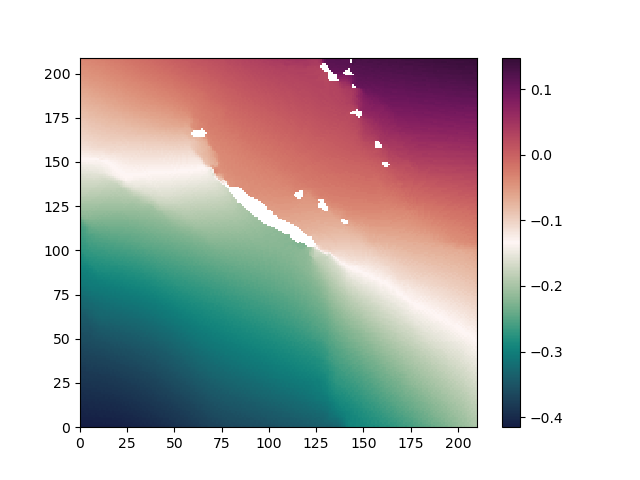

In [16]:
plt.figure()
plt.pcolormesh(bar_fes.bar.sel(time='2014-04-01 03:30:00'),cmap=cmocean.cm.curl
               #,vmin=-0.8, vmax=0.8
               )
plt.colorbar()
plt.show()

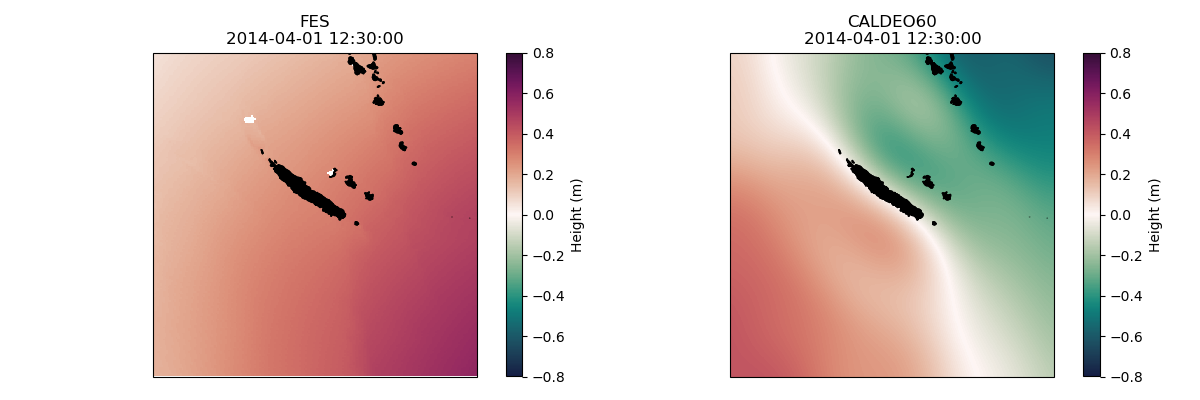

In [18]:
# Fetching your specific time slice as before
date = '2014-04-01 12:30:00'
bar_fes_time_slice = bar_fes.sel(time=date)
bar_caledo_time_slice = bar_caledo.sel(time_counter=date)

# Plotting
plt.figure(figsize=(12, 4))

# Define custom land feature as per the working code snippet
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='black', facecolor='black')

# First subplot for 'bar'
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([159.23333740234375, 172.34999084472656, -28.803945541381836, -15.699763298034668], crs=ccrs.PlateCarree())
mappable1 = ax1.pcolormesh(bar_fes.longitude, bar_fes.latitude, bar_fes_time_slice['bar'], cmap=cmocean.cm.curl, vmin=-0.8, vmax=0.8, transform=ccrs.PlateCarree())
ax1.add_feature(land_feature)
ax1.coastlines(resolution='10m', color='black', linewidth=1)
ax1.set_title(f'FES\n{date}')
plt.colorbar(mappable1, ax=ax1, label='Height (m)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Second subplot for 'ssh_bar'
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([159.23333740234375, 172.34999084472656, -28.803945541381836, -15.699763298034668], crs=ccrs.PlateCarree())
mappable2 = ax2.pcolormesh(bar_caledo.nav_lon, bar_caledo.nav_lat, bar_caledo_time_slice['ssh_bar'], cmap=cmocean.cm.curl, vmin=-0.8, vmax=0.8, transform=ccrs.PlateCarree())
ax2.add_feature(land_feature)
ax2.coastlines(resolution='10m', color='black', linewidth=1)
ax2.set_title(f'CALDEO60\n{date}')
plt.colorbar(mappable2, ax=ax2, label='Height (m)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Show the plot
plt.tight_layout()
plt.show()

In [19]:
# Define the date range
start_date = '2014-02-01T00:30:00'
end_date = '2014-05-31T23:30:00'
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Define the start frame counter
frame_counter_start = 744

# Directory to save the plots
save_dir = '/bettik/PROJECTS/pr-data-ocean/riverama/Frames/FESvsCALEDO'
os.makedirs(save_dir, exist_ok=True)

# Define custom land feature as per the working code snippet
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='black', facecolor='black')

def plot_and_save(date, frame_counter):
    date_str = date.strftime('%Y-%m-%dT%H:%M:%S')
    bar_fes_time_slice = bar_fes.sel(time=date_str)
    bar_caledo_time_slice = bar_caledo.sel(time_counter=date_str)

    # Plotting
    plt.figure(figsize=(12, 4))

    # First subplot for 'bar'
    ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax1.set_extent([159.23333740234375, 172.34999084472656, -28.803945541381836, -15.699763298034668], crs=ccrs.PlateCarree())
    mappable1 = ax1.pcolormesh(bar_fes.longitude, bar_fes.latitude, bar_fes_time_slice['bar'], cmap=cmocean.cm.curl, vmin=-0.8, vmax=0.8, transform=ccrs.PlateCarree())
    ax1.add_feature(land_feature)
    ax1.coastlines(resolution='10m', color='black', linewidth=1)
    ax1.set_title(f'FES\n{date_str}')
    plt.colorbar(mappable1, ax=ax1, label='Height (m)')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')

    # Second subplot for 'ssh_bar'
    ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
    ax2.set_extent([159.23333740234375, 172.34999084472656, -28.803945541381836, -15.699763298034668], crs=ccrs.PlateCarree())
    mappable2 = ax2.pcolormesh(bar_caledo.nav_lon, bar_caledo.nav_lat, bar_caledo_time_slice['ssh_bar'], cmap=cmocean.cm.curl, vmin=-0.8, vmax=0.8, transform=ccrs.PlateCarree())
    ax2.add_feature(land_feature)
    ax2.coastlines(resolution='10m', color='black', linewidth=1)
    ax2.set_title(f'CALDEO60\n{date_str}')
    plt.colorbar(mappable2, ax=ax2, label='Height (m)')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')

    # Save the plot
    save_path = os.path.join(save_dir, f'frame_{frame_counter}.png')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Parallel processing
Parallel(n_jobs=-1)(delayed(plot_and_save)(date, frame_counter_start + i) for i, date in enumerate(date_range))

print('ta da!')


ta da!


LAG Analysis

In [ ]:
import xarray as xr
import numpy as np
from scipy.fftpack import fft, ifft
from joblib import Parallel, delayed

# Load the datasets
bar_fes = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/FES/BAR_FES_2014.nc").load()
bar_caledo = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bar/ssh_bar_*.nc").load()

# Select the time range
bar_fes = bar_fes.sel(time=slice('2014-05-01 00:30', '2014-07-31 23:30'))
bar_caledo = bar_caledo.sel(time_counter=slice('2014-05-01 00:30', '2014-07-31 23:30'))

# Ensure both datasets are aligned
bar_fes_interp = bar_fes.interp(time=bar_caledo.time_counter, method='nearest')

# Select a common spatial area
lat_slice = slice(-28.75, -15.75)
lon_slice = slice(159.2, 172.3)

bar_fes_selected = bar_fes_interp.sel(latitude=lat_slice, longitude=lon_slice)
bar_caledo_selected = bar_caledo.sel(y=slice(0, 209), x=slice(0, 210))

# Helper function to process each grid point
def process_point(fes_point, caledo_point):
    fft_fes_point = fft(fes_point)
    fft_caledo_point = fft(caledo_point)
    csd_point = fft_fes_point * np.conj(fft_caledo_point)
    phase_diff_point = np.angle(csd_point)
    lag_point = ifft(phase_diff_point)
    lag_time_point = lag_point.argmax()
    return lag_time_point

# Flatten the data arrays to 2D (space x time)
fes_data_flat = bar_fes_selected.bar.stack(space=('latitude', 'longitude'))
caled_data_flat = bar_caledo_selected.ssh_bar.stack(space=('y', 'x'))

# Parallel processing
n_jobs = -1  # Use all available CPUs
lag_times = Parallel(n_jobs=n_jobs)(
    delayed(process_point)(fes_data_flat.isel(space=i), caled_data_flat.isel(space=i))
    for i in range(fes_data_flat.shape[0])
)

# Reshape the result back to 2D (latitude x longitude)
lag_times_reshaped = np.reshape(lag_times, (len(bar_fes_selected.latitude), len(bar_fes_selected.longitude)))

# Create a DataArray for the lag times
lag_time_da = xr.DataArray(lag_times_reshaped, coords=[bar_fes_selected.latitude, bar_fes_selected.longitude], dims=['latitude', 'longitude'])

# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(lag_time_da, xticklabels=10, yticklabels=10, cmap='viridis')
plt.title('Heatmap of Lag Values')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()
